# Predicting Future Crime Rates with Facebook Prophet 

## 78701

In [1]:
# importing necessary libraries and configurations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import logging
import warnings

warnings.filterwarnings("ignore")
logging.getLogger("fbprophet").setLevel(logging.ERROR)
plt.style.use("bmh")
%matplotlib inline

In [2]:
# loading datasets
df = pd.read_csv("df_01.csv")

In [3]:
# data cleaning and indexing

drop = ["zip_code", "latitude", "longitude"]

df.drop(drop, axis=1, inplace=True)
df.occurred_date = df.occurred_date.astype("datetime64")
df.set_index(["occurred_date"], inplace=True)
df.sort_index(inplace=True)

PUBLIC INTOXICATION            17150
THEFT                          15793
BURGLARY OF VEHICLE             9274
WARRANT ARREST NON TRAFFIC      8966
DWI                             8325
ASSAULT WITH INJURY             7539
VIOL CITY ORDINANCE - OTHER     6187
POSS OF DRUG PARAPHERNALIA      6049
CRIMINAL MISCHIEF               5830
CRIMINAL TRESPASS               3921
Name: highest_offense_description, dtype: int64

PUBLIC INTOXICATION            0.101653
THEFT                          0.093609
BURGLARY OF VEHICLE            0.054969
WARRANT ARREST NON TRAFFIC     0.053144
DWI                            0.049344
ASSAULT WITH INJURY            0.044686
VIOL CITY ORDINANCE - OTHER    0.036672
POSS OF DRUG PARAPHERNALIA     0.035854
CRIMINAL MISCHIEF              0.034556
CRIMINAL TRESPASS              0.023241
Name: highest_offense_description, dtype: float64

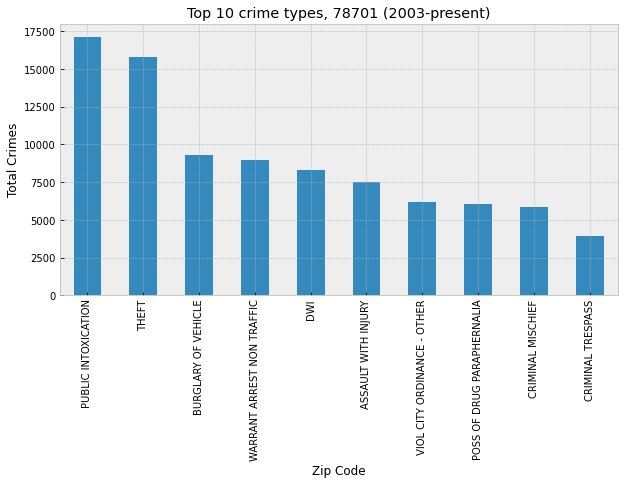

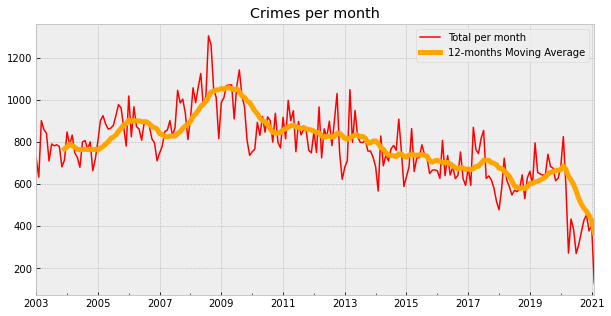

In [4]:
# Create and show dataframe for crime rates by type

display(df.highest_offense_description.value_counts().head(10))
display(df.highest_offense_description.value_counts(normalize=True).head(10))

# Visualizing the top 10 crime types

df.highest_offense_description.value_counts().head(10).plot.bar(
    title="Top 10 crime types, 78701 (2003-present)",
    figsize=(10, 5),
    xlabel="Zip Code",
    ylabel="Total Crimes",
)
plt.show()

# Using resample 'M' and rolling window 12

plt.figure(figsize=(10, 5))
df.resample("M").size().plot(color="red", linewidth=1.5, label="Total per month")
df.resample("M").size().rolling(window=12).mean().plot(
    color="orange", linewidth=5, label="12-months Moving Average"
)
plt.title("Crimes per month")
plt.xlabel("")
plt.legend()
plt.show()

PUBLIC INTOXICATION            17150
THEFT                          15793
BURGLARY OF VEHICLE             9274
WARRANT ARREST NON TRAFFIC      8966
DWI                             8325
ASSAULT WITH INJURY             7539
VIOL CITY ORDINANCE - OTHER     6187
POSS OF DRUG PARAPHERNALIA      6049
CRIMINAL MISCHIEF               5830
CRIMINAL TRESPASS               3921
Name: highest_offense_description, dtype: int64

PUBLIC INTOXICATION  THEFT  BURGLARY OF VEHICLE  \
occurred_date                                                    
2020-10-31                      19     46                   16   
2020-11-30                      17     35                   28   
2020-12-31                       9     38                   21   
2021-01-31                       8     42                   14   
2021-02-28                       2      9                    8   

               CRIMINAL TRESPASS  DWI  CRIMINAL MISCHIEF  ASSAULT WITH INJURY  \
occurred_date                                                                   
2020-10-31                    12   14                 21                   28   
2020-11-30                     3   15                 24                   30   
2020-12-31                    11   11                 21                   19   
2021-01-31                    17   21                 25                   30   
2021-02-28                     4    7                  7                    8   

               TOTAL  
occurred_date         
2020-10-31       156  
2020-11-30       152  
2020-12-31       130  
2021-01-31       157  
2021-02-28        45

<Figure size 432x288 with 0 Axes>

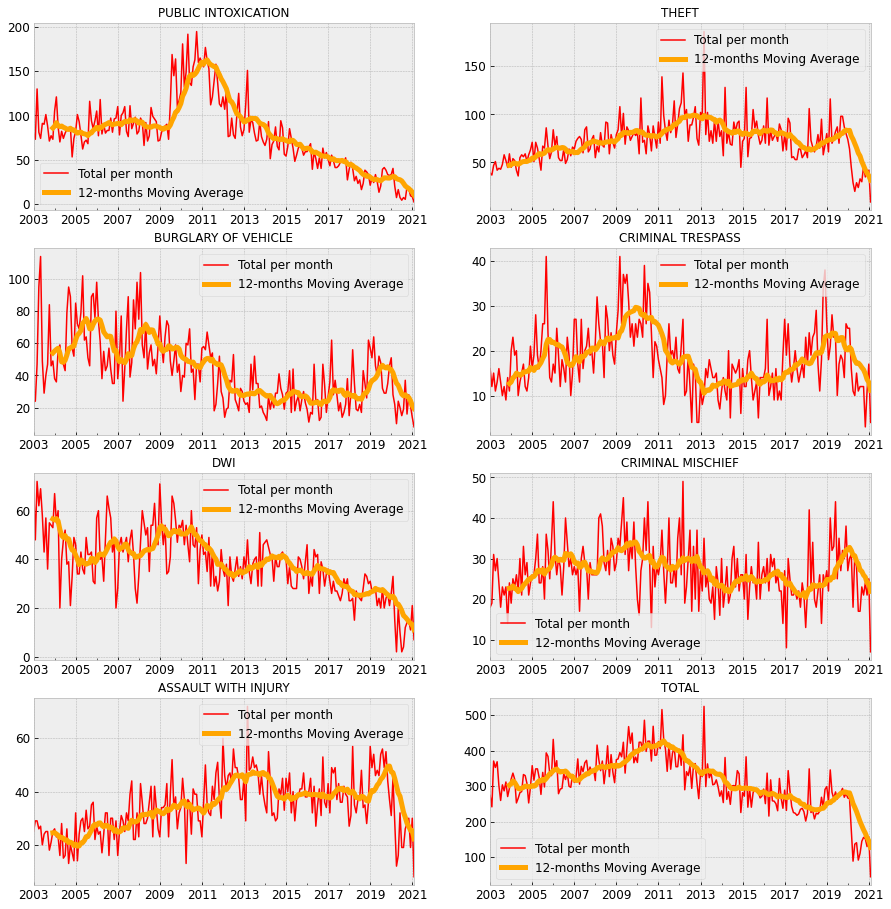

-----------------------------------------------
 Calculating and visualizing the 1st difference
-----------------------------------------------


<Figure size 432x288 with 0 Axes>

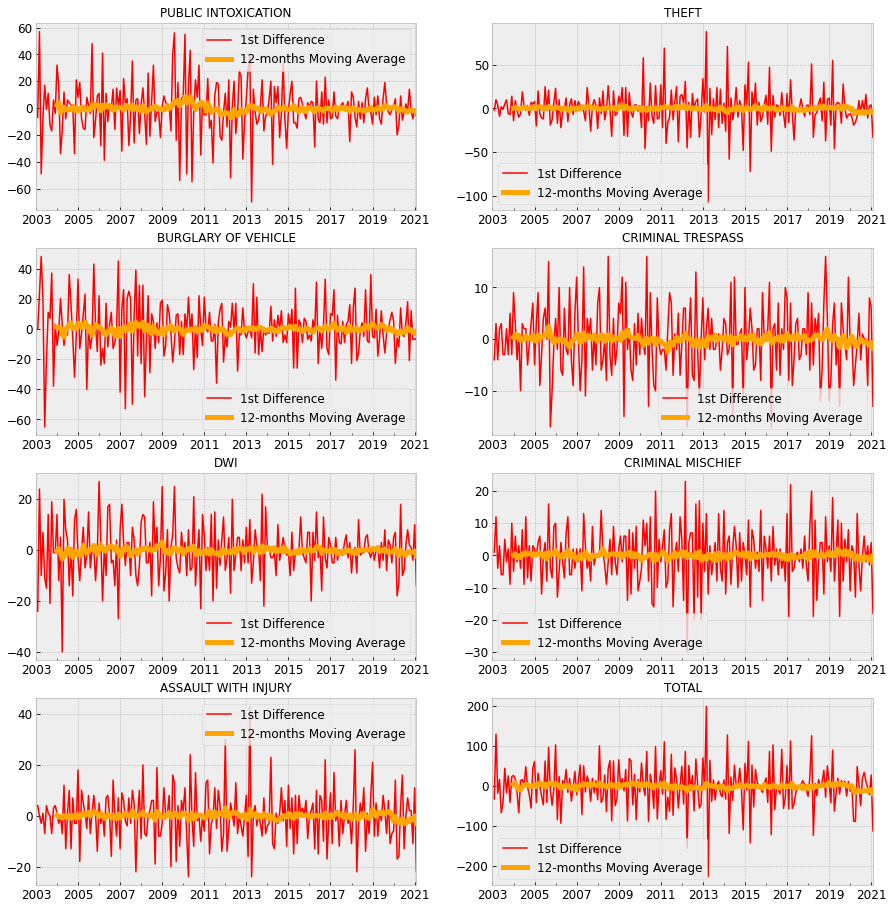

In [5]:
display(df["highest_offense_description"].value_counts().head(10))

df2 = df.query(
    'highest_offense_description == ["PUBLIC INTOXICATION", "THEFT", "CRIMINAL MISCHIEF", "ASSAULT WITH INJURY", "BURGLARY OF VEHICLE", "DWI", "CRIMINAL TRESPASS"]'
)

monthly = pd.DataFrame(
    df2[df2["highest_offense_description"] == "PUBLIC INTOXICATION"]
    .resample("M")
    .size()
)
monthly.columns = ["PUBLIC INTOXICATION"]

for i in df2["highest_offense_description"].unique():
    monthly[i] = pd.DataFrame(
        df2[df2["highest_offense_description"] == i].resample("M").size()
    )

monthly["TOTAL"] = monthly.sum(axis=1)

crimeType = monthly.columns

display(monthly.tail())

plt.figure(1)
plt.figure(figsize=(15, 20))

i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].plot(color="red", linewidth=1.5, label="Total per month")
    monthly[eachCrime].rolling(window=12).mean().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1
plt.show()

print("-----------------------------------------------")
print(" Calculating and visualizing the 1st difference")
print("-----------------------------------------------")
# Initiate the figure and define size
plt.figure(1)
plt.figure(figsize=(15, 20))

# Using a for loop to plot each type of crime with a moving average
i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].diff().plot(color="red", linewidth=1.5, label="1st Difference")
    monthly[eachCrime].rolling(window=12).mean().diff().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1

In [6]:
# Create a data frame with the 1st difference

montlhy_1stDiff = monthly.diff().dropna()

# Create a data frame with the results of the ADF test for each type

adfullerResults = pd.DataFrame(
    columns=crimeType,
    index=["ADF", "Critical Value 1%", "Critical Value 5%", "p-value"],
)
for eachType in crimeType:
    adf = adfuller(montlhy_1stDiff[eachType])
    adfullerResults[eachType] = (
        "{:.4f}".format(adf[0]),
        "{:.4f}".format(adf[4]["1%"]),
        "{:.4f}".format(adf[4]["5%"]),
        "{:.4f}".format(adf[1]),
    )
adfullerResults

PUBLIC INTOXICATION    THEFT BURGLARY OF VEHICLE  \
ADF                           -2.8855  -4.5569             -5.3622   
Critical Value 1%             -3.4631  -3.4628             -3.4631   
Critical Value 5%             -2.8760  -2.8758             -2.8760   
p-value                        0.0471   0.0002              0.0000   

                  CRIMINAL TRESPASS      DWI CRIMINAL MISCHIEF  \
ADF                         -7.4963  -8.1729           -9.0543   
Critical Value 1%           -3.4625  -3.4622           -3.4619   
Critical Value 5%           -2.8757  -2.8755           -2.8754   
p-value                      0.0000   0.0000            0.0000   

                  ASSAULT WITH INJURY    TOTAL  
ADF                           -4.0924  -3.2707  
Critical Value 1%             -3.4630  -3.4633  
Critical Value 5%             -2.8759  -2.8760  
p-value                        0.0010   0.0162

'PUBLIC INTOXICATION'

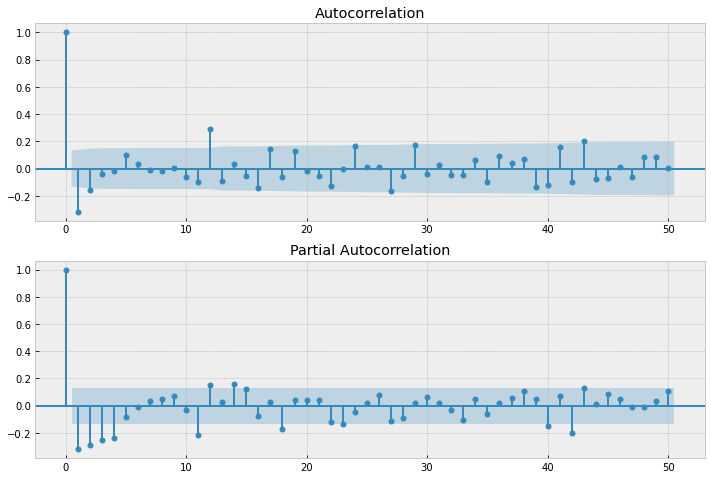

In [7]:
display(montlhy_1stDiff[crimeType[0]].name)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(montlhy_1stDiff[crimeType[0]], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(montlhy_1stDiff[crimeType[0]], lags=50, ax=ax2)

In [8]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [9]:
# Creating a function to use a pipeline
def myArima(crimeTypeSeries):
    print("Training for:", crimeTypeSeries.name)
    lowestAIC = 999999999
    bestOrder = 0
    bestSeasonal_order = 0
    i = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    crimeTypeSeries, order=param, seasonal_order=param_seasonal
                )
                results = mod.fit()
                newAIC = results.aic
                if newAIC < lowestAIC:
                    lowestAIC = newAIC
                    bestOrder = param
                    bestSeasonal_order = param_seasonal
                i = i + 1
                print("\r", "Calculating: {:.0f}%".format(i / 64 * 100), end="")
            except:
                i = i + 1
                print("\r", "Calculating: {:.0f}%".format(i / 64 * 100), end="")
                continue
    print("\nBest parameters: SARIMA{}x{}12".format(param, param_seasonal))
    mod = sm.tsa.statespace.SARIMAX(
        crimeTypeSeries, order=bestOrder, seasonal_order=bestSeasonal_order
    )
    results = mod.fit()
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    pred = results.get_prediction(start=168, end=216, dynamic=False)
    pred_ci = pred.conf_int()
    pred_ci.head()
    plt.figure(figsize=(15, 6))
    ax = crimeTypeSeries.plot(label="observed")
    plt.title("Actual and Forecast", fontsize=12)
    pred.predicted_mean.plot(
        ax=ax, label="One-step ahead forecast", color="red", alpha=0.7, lw=4
    )
    ax.fill_between(
        pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="r", alpha=0.3
    )
    ax.set_xlabel("Years")
    ax.set_ylabel("Number of crime")
    plt.legend()
    plt.show()
    return results

Training for: PUBLIC INTOXICATION
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


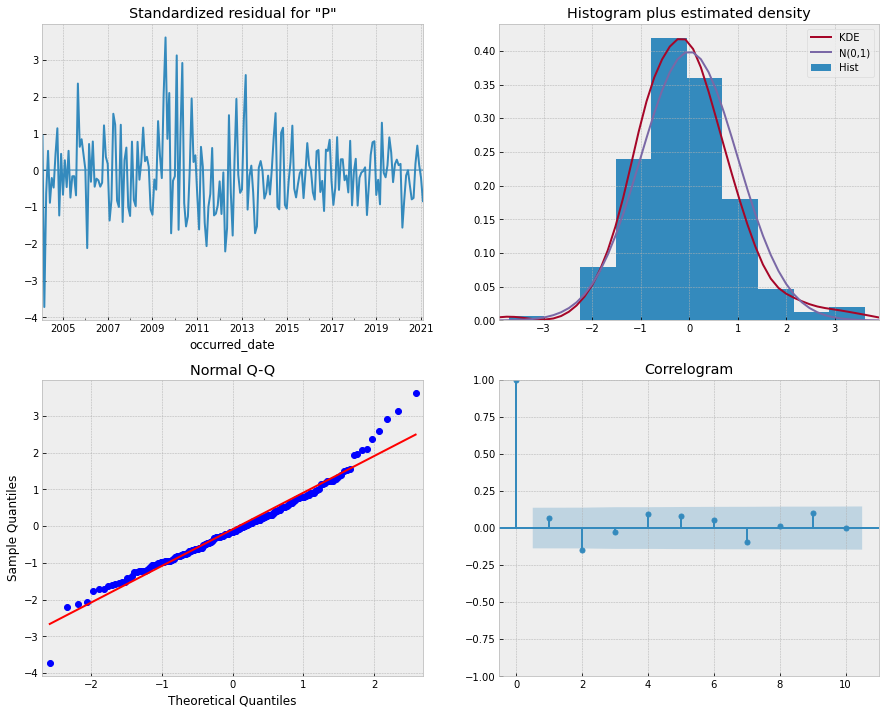

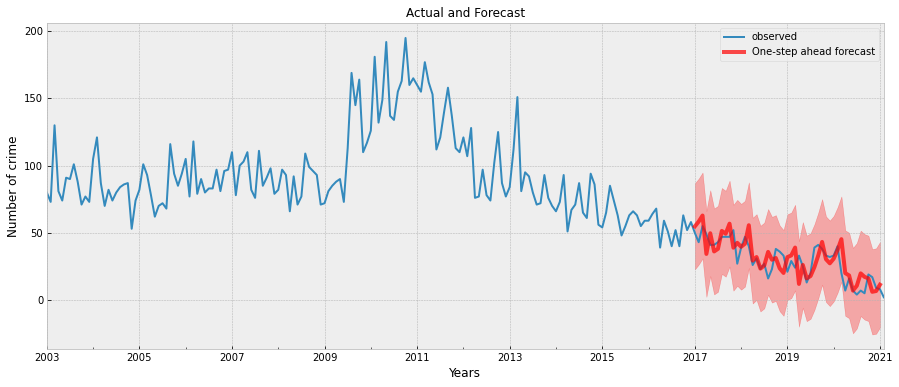

Training for: THEFT
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


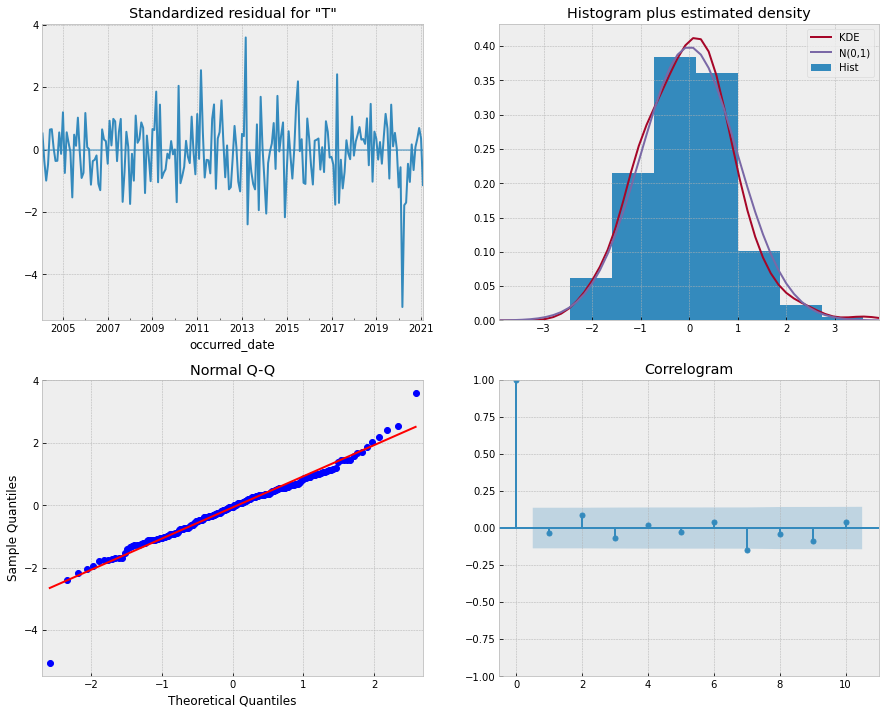

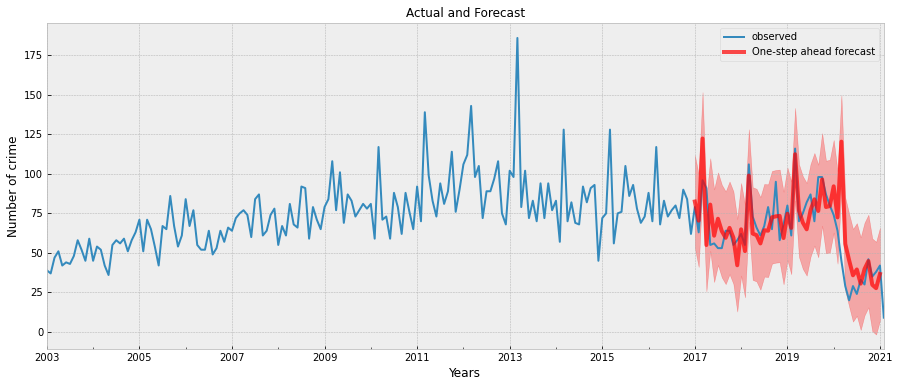

Training for: BURGLARY OF VEHICLE
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


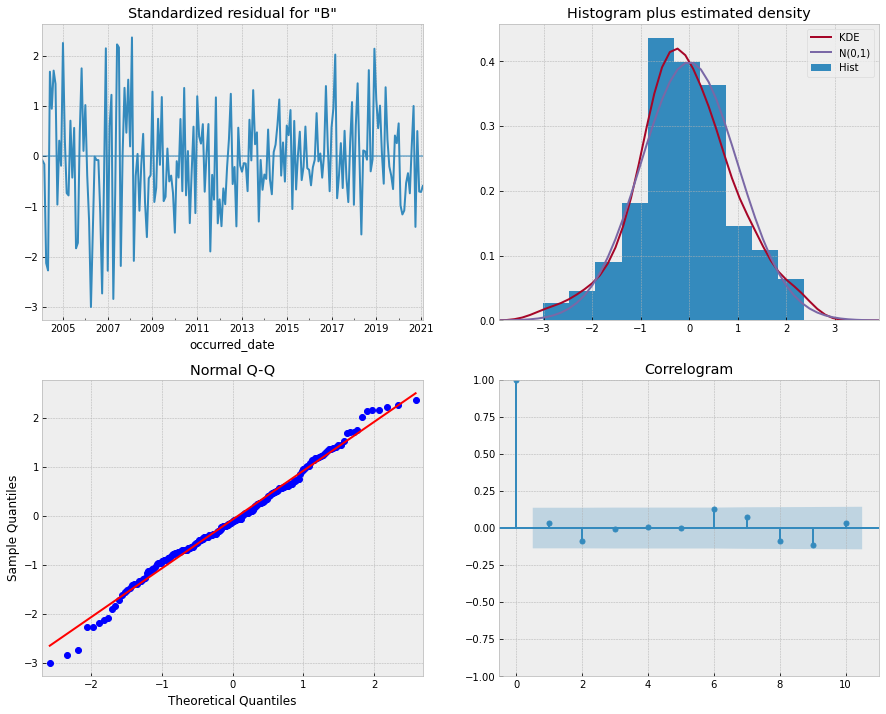

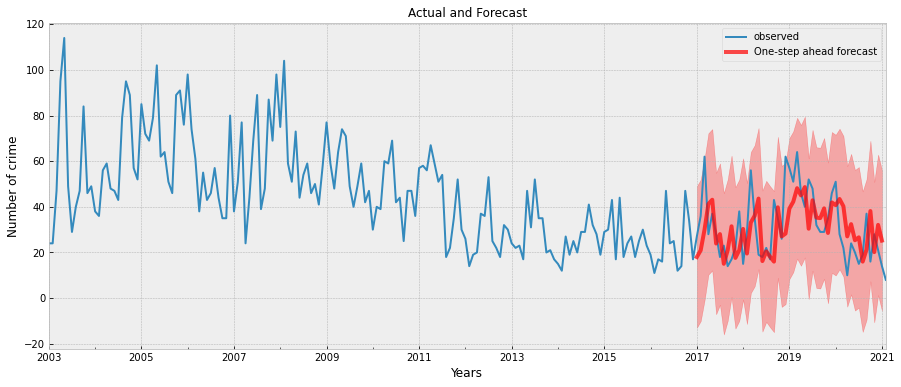

Training for: CRIMINAL TRESPASS
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


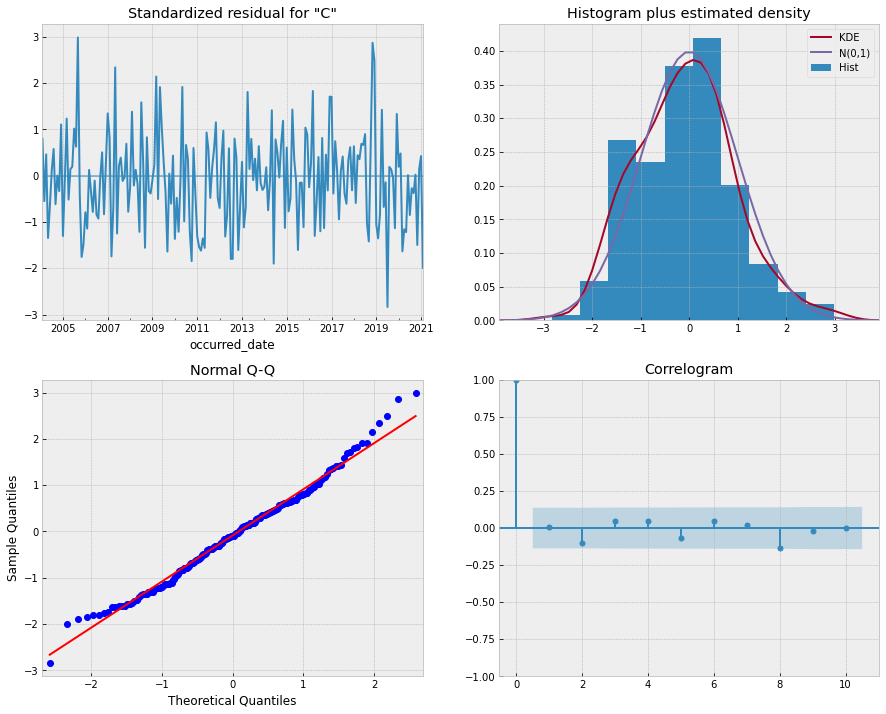

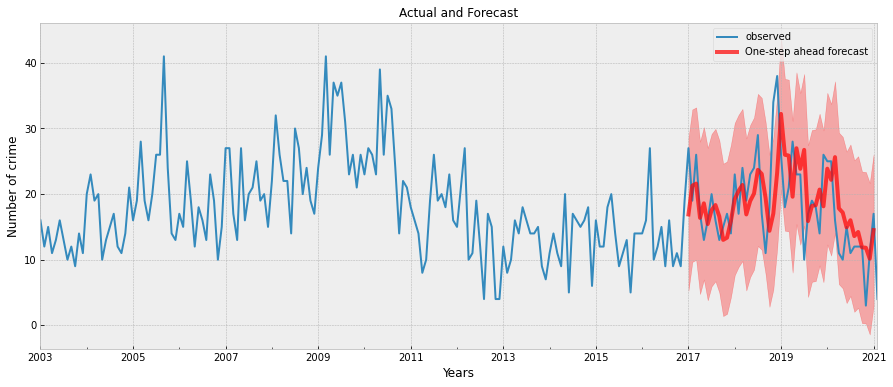

Training for: DWI
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


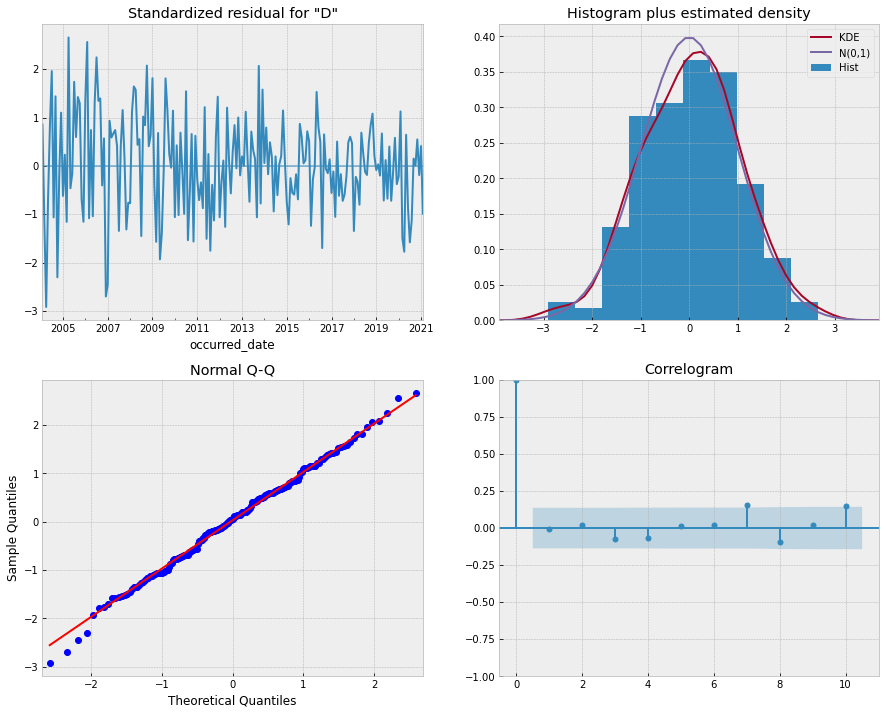

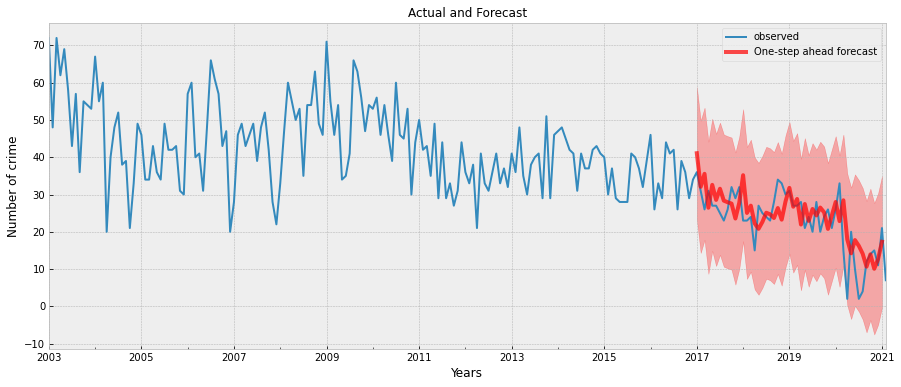

Training for: CRIMINAL MISCHIEF
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


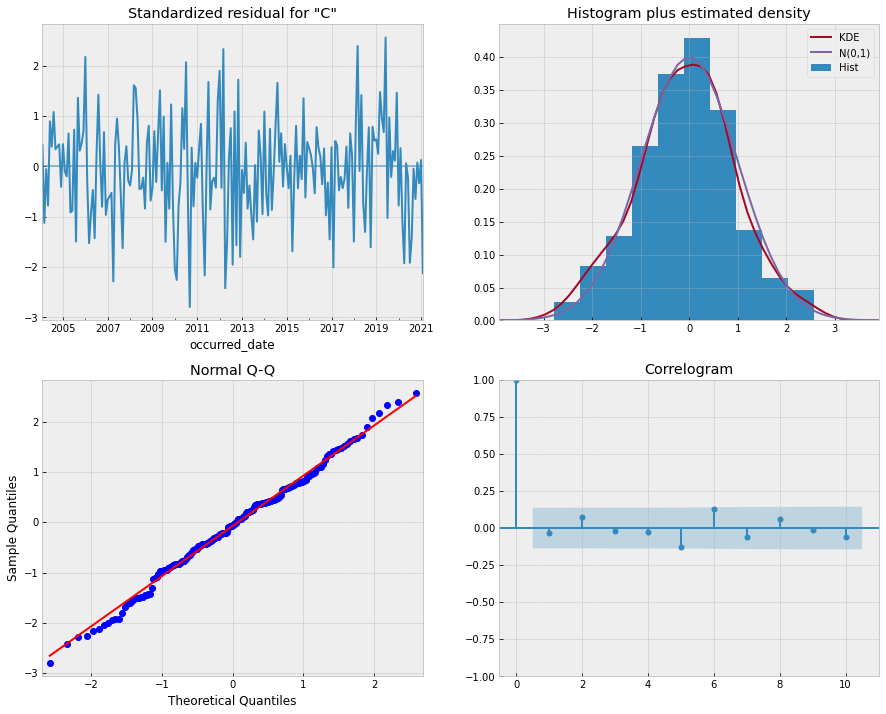

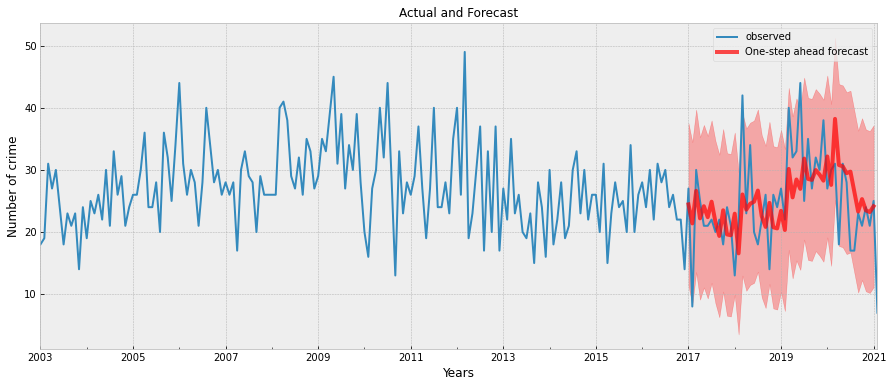

Training for: ASSAULT WITH INJURY
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


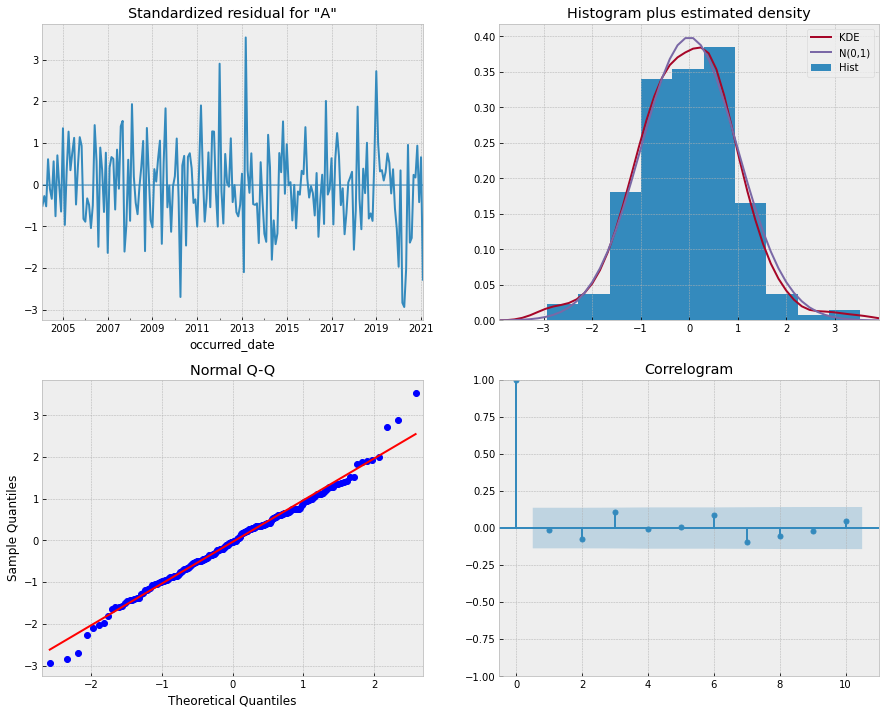

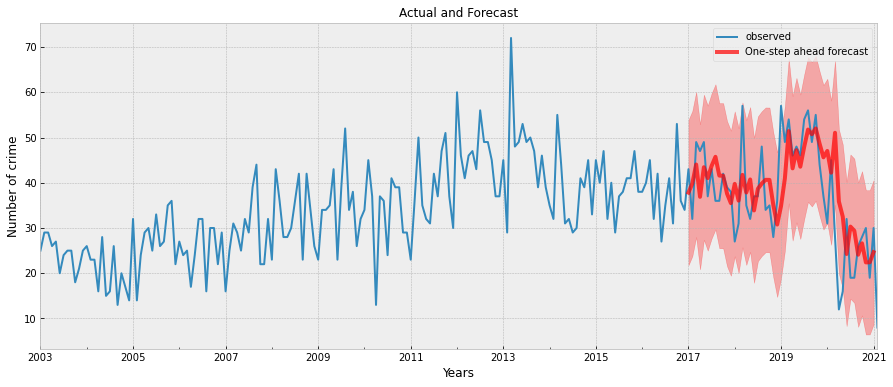

Training for: TOTAL
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


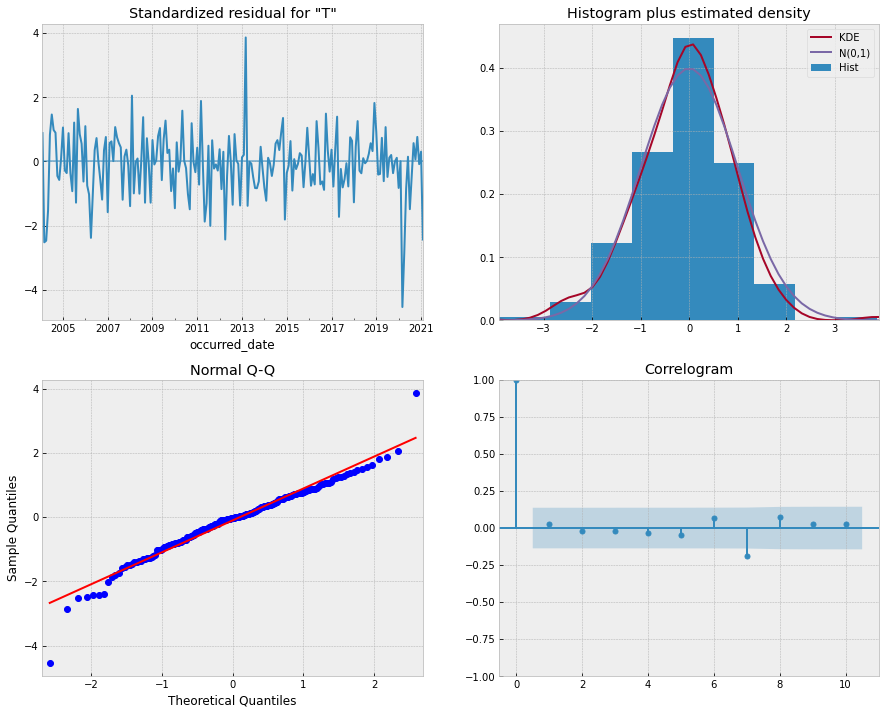

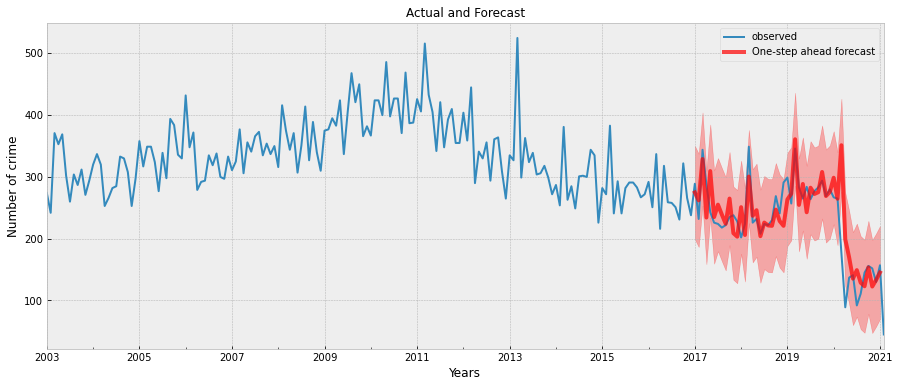

In [10]:
results = []
for i in crimeType:
    results.append(myArima(monthly[i]))

In [11]:
predictions = []
for i in range(0, len(results)):
    predictions.append(
        results[i].get_prediction(start=204, end=228, dynamic=False).predicted_mean
    )

In [12]:
# Calculating MAPE error
predictions = pd.DataFrame(predictions)
predictions = predictions.transpose()
predictions.columns = monthly.columns
errors = (monthly - predictions) / monthly
errors.dropna(how="all", inplace=True)
n = len(errors)

MAPE = round((errors.abs().sum() / n) * 100, 2)
print(
    "The Mean Absolute Percentage Error for each type for the year 01/2020 to 12/2021"
)
display(MAPE)

The Mean Absolute Percentage Error for each type for the year 01/2020 to 12/2021


PUBLIC INTOXICATION    125.60
THEFT                   57.06
BURGLARY OF VEHICLE     67.28
CRIMINAL TRESPASS       64.14
DWI                    157.31
CRIMINAL MISCHIEF       35.53
ASSAULT WITH INJURY     63.26
TOTAL                   42.45
dtype: float64

In [13]:
# Formulating the confidence interval
predictions_ci = []
for i in range(0, len(results)):
    predictions_ci.append(
        results[i].get_prediction(start=204, end=228, dynamic=False).conf_int()
    )

# display(predictions_ci)

# Building a forecast table
def forecastMonth(year_month):
    for i in range(0, 9):
        pred_df = round(predictions.iloc[:, i : i + 1][year_month], 0)
        ci_df = round(predictions_ci[i][year_month], 0)
        ci_df.columns = ["Lower CI", "Upper CI"]
        frames = (pred_df, ci_df)
        display(pd.concat(frames, axis=1))


forecastMonth("2021-02")

PUBLIC INTOXICATION  Lower CI  Upper CI
2021-02-28                 16.0     -16.0      47.0

THEFT  Lower CI  Upper CI
2021-02-28   26.0      -3.0      55.0

BURGLARY OF VEHICLE  Lower CI  Upper CI
2021-02-28                 17.0     -13.0      48.0

CRIMINAL TRESPASS  Lower CI  Upper CI
2021-02-28               16.0       4.0      27.0

DWI  Lower CI  Upper CI
2021-02-28  16.0      -2.0      33.0

CRIMINAL MISCHIEF  Lower CI  Upper CI
2021-02-28               21.0       8.0      34.0

ASSAULT WITH INJURY  Lower CI  Upper CI
2021-02-28                 27.0      11.0      42.0

TOTAL  Lower CI  Upper CI
2021-02-28  138.0      63.0     214.0

IndexError: list index out of range

## Predicting crime rates with Facebook Prophet 

### Modeling the data as-is

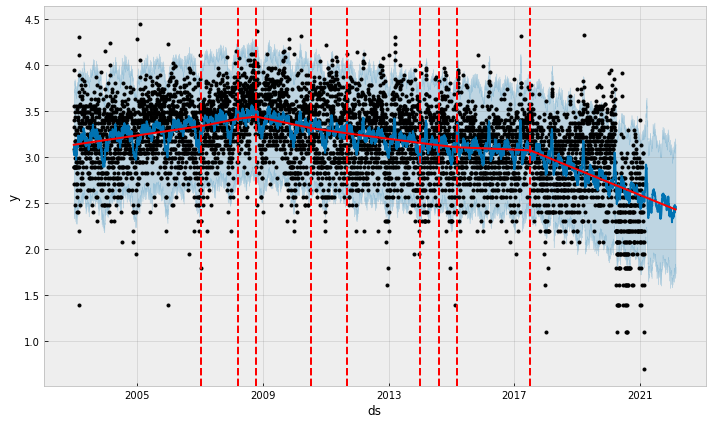

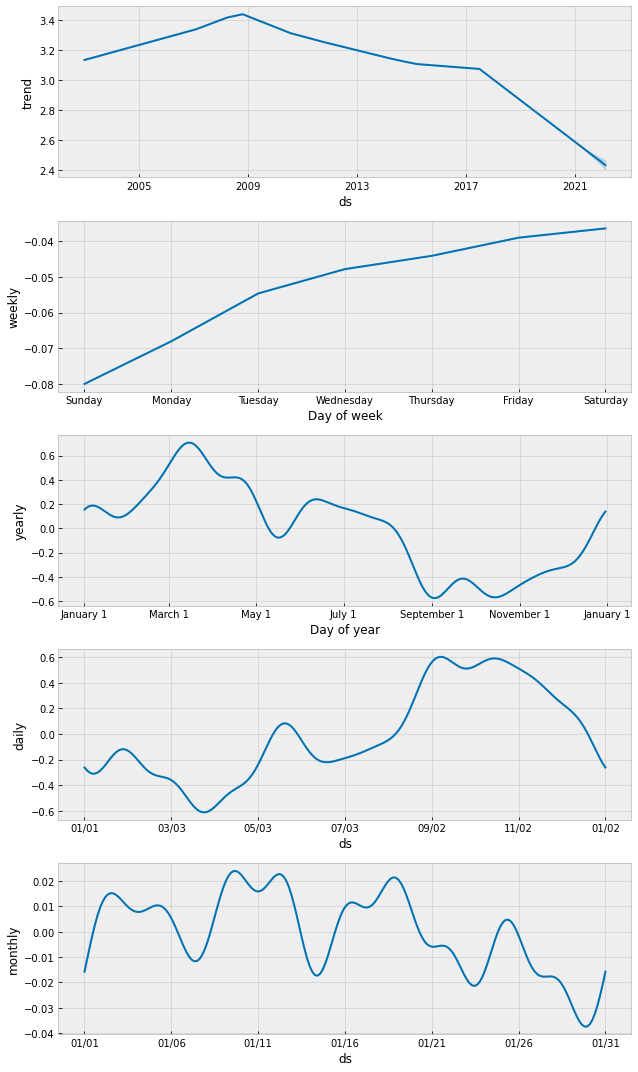

In [14]:
# Prepping to forecast
df_fbprophet = df.copy()
df_m = df_fbprophet.resample("D").size().reset_index()
df_m.columns = ["date", "daily_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "daily_crime_count": "y"})
df_m_final["y"] = np.log(df_m_final["y"])
# df_m_final["y"] = pd.to_numeric(df_m_final["y"])
y = df_m_final["y"].to_frame()
y.index = df_m_final["ds"]
n = np.int(y.count())

# Fitting and configuring the model
m = Prophet(interval_width=0.95)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52, fourier_order=10)
m.add_seasonality(name="daily", period=366, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=366, freq="D")

forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

fig2 = m.plot_components(forecast)

fig2_1 = plot_plotly(m, forecast)
fig2_1

In [15]:
# The forecast is 'log transformed', so we need to 'inverse' it back by using the exp
forecast_df_exp = np.exp(forecast[["yhat", "yhat_lower", "yhat_upper"]])
forecast_df_exp.index = forecast["ds"]

# Calculating MAPE error 
error = forecast_df_exp["yhat"] - y["y"]
MAPE_df = (error / y["y"]).abs().sum() / n * 100
round(MAPE_df, 2)

665.15

### Mitigating outlier effects on moodel accuracy 

In [16]:
# Make another copy of the data frame as m2
df_prophet2 = df_m_final.copy()

# Define the Upper Control Limit and Lower Control Limit as 3 standard deviations from the mean
ucl = df_prophet2.mean() + df_prophet2.std() * 3
lcl = df_prophet2.mean() - df_prophet2.std() * 3

# display the number of outliers found
print(
    "Above 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] > ucl["y"]]["y"].count(),
    "entries",
)
print(
    "Below 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] < lcl["y"]]["y"].count(),
    "entries",
)

Above 3 standard deviations:  1 entries
Below 3 standard deviations:  55 entries


In [ ]:
# Remove them by setting their value to None. Prophet says it can handle null values.
df_prophet2.loc[df_prophet2["y"] > ucl["y"], "y"] = None
df_prophet2.loc[df_prophet2["y"] < lcl["y"], "y"] = None

# Log transformation
df_prophet2["y"] = np.log(df_prophet2["y"])
# df_prophet2["y"] = pd.to_numeric(df_prophet2["y"])

# Run Prophet using model 2
m2 = Prophet(interval_width=0.95)
m2.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m2.add_seasonality(name="weekly", period=52, fourier_order=10)
m2.add_seasonality(name="daily", period=366, fourier_order=10)
m2.fit(df_prophet2)

future = m2.make_future_dataframe(periods=366)

forecast_m2 = m2.predict(future)

fig_m2 = m2.plot(forecast_m2)
a = add_changepoints_to_plot(fig_m2.gca(), m2, forecast_m2)

fig2m2 = m2.plot_components(forecast_m2)

fig2_1m2 = plot_plotly(m2, forecast_m2)
fig2_1m2

In [ ]:
# Re-inversing the forecast
forecast_m2_exp = np.exp(forecast_m2[["yhat", "yhat_lower", "yhat_upper"]])
forecast_m2_exp.index = forecast_m2["ds"]

# RecalculatinG MAPE error
error = forecast_m2_exp["yhat"] - y["y"]
MAPE_m2 = (error / y["y"]).abs().sum() / n * 100
round(MAPE_m2, 2)

  horizon       mse      rmse       mae      mape     mdape  coverage
0 36 days  0.017858  0.133632  0.111327  0.100022  0.090731  0.907801
1 37 days  0.018571  0.136275  0.113097  0.102322  0.091353  0.900709
2 38 days  0.019484  0.139584  0.115823  0.105953  0.093648  0.893617
3 39 days  0.020316  0.142534  0.117312  0.108434  0.092880  0.879433
4 40 days  0.019362  0.139148  0.114479  0.105779  0.090731  0.895390


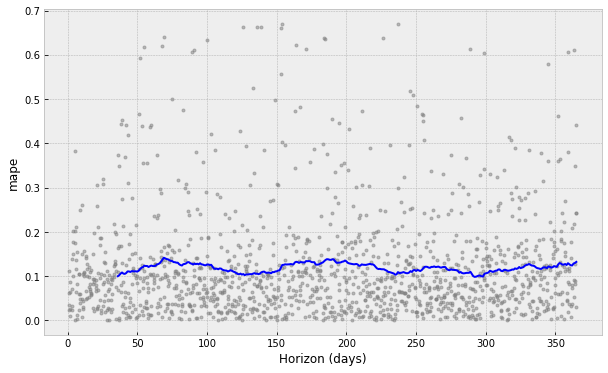

In [19]:
# Doing a diagnostic and performance metrics check visualizing the results 

b = cross_validation(m2, initial="5110 days", period="365 days", horizon="365 days")

p = performance_metrics(b)
print(p.head())

fig4 = plot_cross_validation_metric(b, metric="mape")